<a href="https://colab.research.google.com/github/sugarghost/hanghae99_AI_PLUS_2/blob/main/1_5_HOMEWORK_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms


## Dataset 및 activation 함수 변경
    - Dataset을 MNIST에서 [CIFAR10](https://pytorch.org/vision/stable/generated/torchvision.datasets.CIFAR10.html)으로 변경해줍니다.
    - Activation 함수를 `nn.ReLU`에서 `nn.LeakyReLU`로 변경해줍니다.
    - 학습 인자는 `n_epochs` = 50, `batch_size` = 256로 설정합니다.

In [ ]:
# transform = transforms.ToTensor()
# [MY CODE] 성능 향상을 위한 데이터 전처리 추가
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

batch_size = 256

# [MY CODE] Data SET을 CIFAR10으로 변경
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)


Files already downloaded and verified
Files already downloaded and verified


## [MY CODE] Activation 함수를 nn.LeakyReLU로 변경

In [ ]:
from torch import nn


class Model(nn.Module):
  def __init__(self, input_dim, n_dim):
    super().__init__()

    self.layer1 = nn.Linear(input_dim, n_dim)
    self.layer2 = nn.Linear(n_dim, n_dim)
    self.layer3 = nn.Linear(n_dim, 10)
    # [MY CODE] Activation 함수를 nn.LeakyReLU로 변경
    self.act = nn.LeakyReLU()

  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    x = self.act(self.layer1(x))
    x = self.act(self.layer2(x))
    x = self.layer3(x)

    return x


## [MY CODE] 제공된 측정 함수 추가

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

train_accs, test_accs = [], []
def accuracy(model, dataloader):
  cnt = 0
  acc = 0

  for data in dataloader:
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model(inputs)
    preds = torch.argmax(preds, dim=-1)

    cnt += labels.shape[0]
    acc += (labels == preds).sum().item()

  return acc / cnt

def plot_acc(train_accs, test_accs, label1='train', label2='test'):
  x = np.arange(len(train_accs))

  plt.plot(x, train_accs, label=label1)
  plt.plot(x, test_accs, label=label2)
  plt.legend()
  plt.show()

## [MY CODE] 여러 모델을 테스트하기 위해 학습 로직 분리

In [ ]:
def train(model, optimizer, criterion, train_loader, test_loader, n_epochs):
    train_accs, test_accs = [], []

    for epoch in range(n_epochs):
      total_loss = 0.

      model.train()
      for data in trainloader:
        model.zero_grad()
        inputs, labels = data
        inputs, labels = inputs.to('cuda'), labels.to('cuda')

        preds = model(inputs)
        loss = criterion(preds, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

      with torch.no_grad():
        model.eval()
        # Epoch별 Train/Test 정확도 계산
        train_acc = accuracy(model, trainloader)
        test_acc = accuracy(model, testloader)
        train_accs.append(train_acc)
        test_accs.append(test_acc)

        print(f"Epoch {epoch:3d} | Loss: {total_loss} | Train Acc: {train_acc:.4f} | Test Acc: {test_acc:.4f}")

    return train_accs, test_accs

## CIFAR10의 입력 shape 확인
    - CIFAR10은 MNIST와 다른 입력 shape을 가지고 있습니다.
    - 입력 shape은 model을 선언할 때 중요하기 때문에 MNIST 실습 자료에서 사용한 방식과 똑같이 shape을 확인해주시면 됩니다.

## SGD와 Adam 성능 비교
    - 먼저 [Adam optimizer](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html)을 사용하여 학습하는 코드를 구현합니다.
    - (Plot 1) SGD와 Adam을 학습시킨 후 각각의 epoch에 대한 train 정확도를 plot합니다.

## [LOG] SGD, Adam 성능 비교 출력

In [ ]:
from torch.optim import SGD
from torch.optim import Adam
import torch.optim as optim
input_dim = 3 * 32 * 32  # CIFAR10 입력 차원
n_dim = 512              # 초기 은닉층 크기
n_epochs = 50            # 학습 반복 횟수
lr = 0.001               # 학습률

# [MY_CODE] SGD 사용 버전
model_sgd = Model(input_dim, n_dim).to('cuda')
optimizer_sgd = SGD(model_sgd.parameters(), lr=lr, momentum=0.9)
criterion = nn.CrossEntropyLoss()

print("[S] SGD Optimizer")
sgd_train_accs, sgd_test_accs = train(model_sgd, optimizer_sgd, criterion, trainloader, testloader, n_epochs)
print("[E] SGD Optimizer")

# [MY_CODE] Adam Optimizer 버전
model_adam = Model(input_dim, n_dim).to('cuda')
optimizer_adam = optim.Adam(model_adam.parameters(), lr=lr)

print("[S] Adam Optimizer")
adam_train_accs, adam_test_accs = train(model_adam, optimizer_adam, criterion, trainloader, testloader, n_epochs)
print("[E] Adam Optimizer")

[S] SGD Optimizer
Epoch   0 | Loss: 438.25412917137146 | Train Acc: 0.2641 | Test Acc: 0.2652
Epoch   1 | Loss: 406.7271522283554 | Train Acc: 0.2963 | Test Acc: 0.2943
Epoch   2 | Loss: 383.1186326742172 | Train Acc: 0.3305 | Test Acc: 0.3297
Epoch   3 | Loss: 366.487552523613 | Train Acc: 0.3539 | Test Acc: 0.3535
Epoch   4 | Loss: 354.60795176029205 | Train Acc: 0.3749 | Test Acc: 0.3752
Epoch   5 | Loss: 345.2195975780487 | Train Acc: 0.3896 | Test Acc: 0.3927
Epoch   6 | Loss: 337.3354458808899 | Train Acc: 0.4024 | Test Acc: 0.4041
Epoch   7 | Loss: 330.52100670337677 | Train Acc: 0.4141 | Test Acc: 0.4139
Epoch   8 | Loss: 324.8684288263321 | Train Acc: 0.4239 | Test Acc: 0.4255
Epoch   9 | Loss: 319.96006417274475 | Train Acc: 0.4330 | Test Acc: 0.4340
Epoch  10 | Loss: 315.3820974826813 | Train Acc: 0.4379 | Test Acc: 0.4390
Epoch  11 | Loss: 311.3584393262863 | Train Acc: 0.4479 | Test Acc: 0.4455
Epoch  12 | Loss: 307.6441340446472 | Train Acc: 0.4544 | Test Acc: 0.4563
Epoc

## [LOG] SGD, Adam 정확도 그래프 출력

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54869 (\N{HANGUL SYLLABLE HWAG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44368 (\N{HANGUL SYLLABLE GYO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


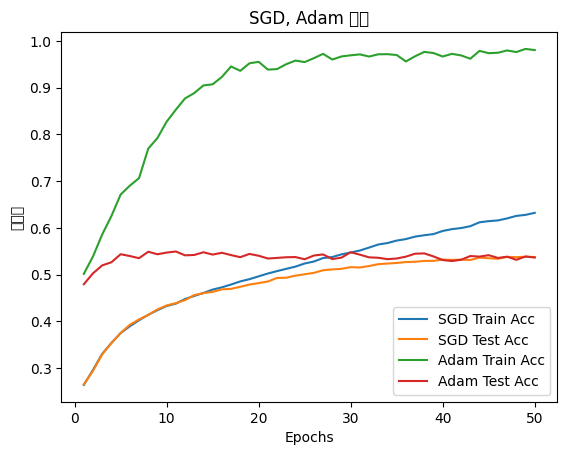

In [ ]:
epochs = range(1, len(sgd_train_accs) + 1)

plt.plot(epochs, sgd_train_accs, label='SGD Train Acc')
plt.plot(epochs, sgd_test_accs, label='SGD Test Acc')
plt.plot(epochs, adam_train_accs, label='Adam Train Acc')
plt.plot(epochs, adam_test_accs, label='Adam Test Acc')

plt.xlabel('Epochs')
plt.ylabel('정확도')
plt.title('SGD, Adam 비교')
plt.legend()
plt.show()

## Leaky ReLU와 Sigmoid 성능 비교
    - Activation 함수가 `nn.Sigmoid`인 class를 새로 정의합니다.
    - (Plot 2) Adam optimizer를 가지고 sigmoid와 leaky ReLU 모델들을 학습한 후, epoch에 따른 train 정확도를 비교합니다.

In [ ]:

## [MY CODE] Sigmoid 모델 추가
class Model_Sigmoid(nn.Module):
  def __init__(self, input_dim, n_dim):
    super().__init__()

    self.layer1 = nn.Linear(input_dim, n_dim)
    self.layer2 = nn.Linear(n_dim, n_dim)
    self.layer3 = nn.Linear(n_dim, 10)

    self.act = nn.Sigmoid()

  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    x = self.act(self.layer1(x))
    x = self.act(self.layer2(x))
    x = self.layer3(x)

    return x


# [MY_CODE] Adam Optimizer Sigmoid 버전 학습
model_sigmoid = Model_Sigmoid(input_dim, n_dim).to('cuda')
optimizer_sigmoid_adam = Adam(model_sigmoid.parameters(), lr=lr)

print("[S] Sigmoid Adam Optimizer")
sigmoid_adam_train_accs, sigmoid_adam_test_accs = train(model_sigmoid, optimizer_sigmoid_adam, criterion, trainloader, testloader, n_epochs)
print("[E] Sigmoid Adam Optimizer")

[S] Sigmoid Adam Optimizer
Epoch   0 | Loss: 354.29245865345 | Train Acc: 0.4240 | Test Acc: 0.4172
Epoch   1 | Loss: 313.125910282135 | Train Acc: 0.4686 | Test Acc: 0.4547
Epoch   2 | Loss: 292.65034878253937 | Train Acc: 0.5026 | Test Acc: 0.4711
Epoch   3 | Loss: 275.00090992450714 | Train Acc: 0.5399 | Test Acc: 0.4830
Epoch   4 | Loss: 259.4147390127182 | Train Acc: 0.5639 | Test Acc: 0.4935
Epoch   5 | Loss: 244.81687116622925 | Train Acc: 0.5984 | Test Acc: 0.4995
Epoch   6 | Loss: 230.86049807071686 | Train Acc: 0.6213 | Test Acc: 0.4987
Epoch   7 | Loss: 216.454150557518 | Train Acc: 0.6479 | Test Acc: 0.5014
Epoch   8 | Loss: 202.53195053339005 | Train Acc: 0.6796 | Test Acc: 0.5056
Epoch   9 | Loss: 187.44433242082596 | Train Acc: 0.7010 | Test Acc: 0.4999
Epoch  10 | Loss: 174.1977150440216 | Train Acc: 0.7281 | Test Acc: 0.5012
Epoch  11 | Loss: 162.0957514643669 | Train Acc: 0.7480 | Test Acc: 0.4993
Epoch  12 | Loss: 147.983232319355 | Train Acc: 0.7632 | Test Acc: 0.49

## [LOG] SGD, Adam, Sigmoid 정확도 그래프 출력

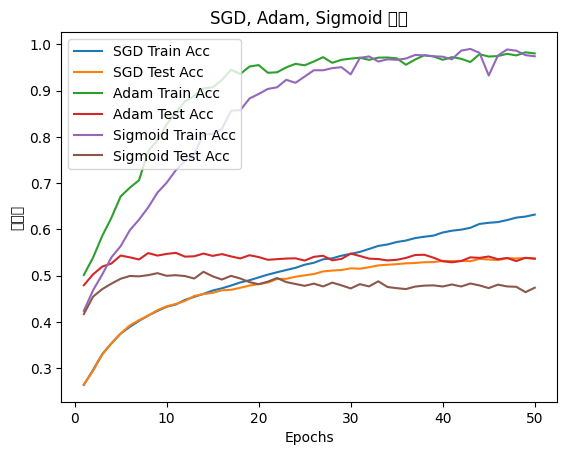

In [ ]:
epochs = range(1, len(sgd_train_accs) + 1)

plt.plot(epochs, sgd_train_accs, label='SGD Train Acc')
plt.plot(epochs, sgd_test_accs, label='SGD Test Acc')
plt.plot(epochs, adam_train_accs, label='Adam Train Acc')
plt.plot(epochs, adam_test_accs, label='Adam Test Acc')
plt.plot(epochs, sigmoid_adam_train_accs, label='Sigmoid Train Acc')
plt.plot(epochs, sigmoid_adam_test_accs, label='Sigmoid Test Acc')

plt.xlabel('Epochs')
plt.ylabel('정확도')
plt.title('SGD, Adam, Sigmoid 비교')
plt.legend()
plt.show()

## Dropout을 적용한 이후의 generalization error 확인
    - PyTorch [dropout](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html)을 leaky ReLU를 사용하는 MLP의 모든 layer에 적용한 class를 새로 정의합니다. Dropout 확률은 0.1로 설정합니다.
            
    - (Plot 3) Adam optimizer를 가지고 dropout을 적용한 모델을 학습한 후, epoch에 따른 train과 test 정확도를 비교합니다.

In [ ]:

## [MY CODE] Dropout 모델 추가
class Model_Dropout(nn.Module):
  def __init__(self, input_dim, n_dim):
    super().__init__()

    self.layer1 = nn.Linear(input_dim, n_dim)
    self.dropout1 = nn.Dropout(p=0.5)  # Dropout 적용
    self.layer2 = nn.Linear(n_dim, n_dim)
    self.dropout2 = nn.Dropout(p=0.5)
    self.layer3 = nn.Linear(n_dim, 10)

    self.act = nn.LeakyReLU(negative_slope=0.01)

  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    x = self.act(self.layer1(x))
    x = self.dropout1(x)  # Dropout 적용
    x = self.act(self.layer2(x))
    x = self.dropout2(x)  # Dropout 적용
    x = self.layer3(x)

    return x


# [MY_CODE] Adam Optimizer Dropout 버전 학습
model_dropout = Model_Dropout(input_dim, n_dim).to('cuda')
optimizer_dropout_adam = optim.Adam(model_dropout.parameters(), lr=lr)

print("[S] Dropout Adam Optimizer")
dropout_adam_train_accs, dropout_adam_test_accs = train(model_dropout, optimizer_dropout_adam, criterion, trainloader, testloader, n_epochs)
print("[E] Dropout Adam Optimizer")

[S] Dropout Adam Optimizer
Epoch   0 | Loss: 353.5944595336914 | Train Acc: 0.4520 | Test Acc: 0.4525
Epoch   1 | Loss: 321.92225110530853 | Train Acc: 0.4765 | Test Acc: 0.4676
Epoch   2 | Loss: 310.30925261974335 | Train Acc: 0.5072 | Test Acc: 0.4908
Epoch   3 | Loss: 301.9838192462921 | Train Acc: 0.5192 | Test Acc: 0.4988
Epoch   4 | Loss: 295.5128549337387 | Train Acc: 0.5351 | Test Acc: 0.5081
Epoch   5 | Loss: 290.3251349925995 | Train Acc: 0.5455 | Test Acc: 0.5051
Epoch   6 | Loss: 285.4155218601227 | Train Acc: 0.5553 | Test Acc: 0.5161
Epoch   7 | Loss: 281.8644517660141 | Train Acc: 0.5636 | Test Acc: 0.5113
Epoch   8 | Loss: 276.98587942123413 | Train Acc: 0.5655 | Test Acc: 0.5171
Epoch   9 | Loss: 273.72374057769775 | Train Acc: 0.5800 | Test Acc: 0.5233
Epoch  10 | Loss: 270.9161573648453 | Train Acc: 0.5847 | Test Acc: 0.5251
Epoch  11 | Loss: 268.6624164581299 | Train Acc: 0.5928 | Test Acc: 0.5309
Epoch  12 | Loss: 264.2630115747452 | Train Acc: 0.6019 | Test Acc: 0

## [LOG] SGD, Adam, Sigmoid 정확도 그래프 출력

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54869 (\N{HANGUL SYLLABLE HWAG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44368 (\N{HANGUL SYLLABLE GYO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


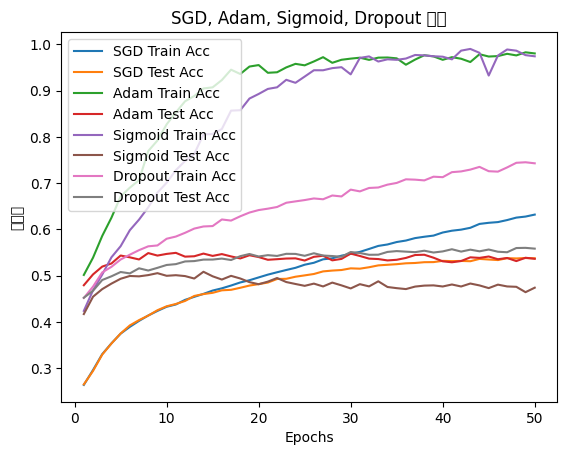

In [ ]:
epochs = range(1, len(sgd_train_accs) + 1)

plt.plot(epochs, sgd_train_accs, label='SGD Train Acc')
plt.plot(epochs, sgd_test_accs, label='SGD Test Acc')
plt.plot(epochs, adam_train_accs, label='Adam Train Acc')
plt.plot(epochs, adam_test_accs, label='Adam Test Acc')
plt.plot(epochs, sigmoid_adam_train_accs, label='Sigmoid Train Acc')
plt.plot(epochs, sigmoid_adam_test_accs, label='Sigmoid Test Acc')
plt.plot(epochs, dropout_adam_train_accs, label='Dropout Train Acc')
plt.plot(epochs, dropout_adam_test_accs, label='Dropout Test Acc')

plt.xlabel('Epochs')
plt.ylabel('정확도')
plt.title('SGD, Adam, Sigmoid, Dropout 비교')
plt.legend()
plt.show()